## 과제 2

이 과제에서는 전방 종방향의 차량 모델을 구현합니다.
이 모델은 스로틀 입력을 받아 종방향 동적 방정식을 이용하여 지동차를 움직이게 됩니다.
모델이 구현되면 모델을 테스트하기 위한 작은 도로 경사면이 주어집니다.

모델에 대한 입력은 스로틀 백분율 $x_\theta \in [0,1]$ 이고 이것을 통해 엔진에 토크를 제공하고 차량을 가속합니다.

동적 방정식은 스로틀 입력을 휠 속도로 변환하는 여러 단계로 구성됩니다.
단계는 엔진 -> 토크 컨버터 -> 변속기 -> 휠로 이뤄지며 이런 단계는 다음과 같은 결합된 엔진 동적 방정식에서 사용되는 $J_e$로 함께 묶입니다.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

여기서 $T_e$는 엔진 토크, $GR$는 기어비, $r_{eff}$는 유효 반경, $m$는 차량의 질량, $x$는 차량 위치, $F_x$는 타이어의 힘이고 $F_{load}$는 총 하중의 힘입니다. 

엔진 토크는 단순화된 2차 모델을 사용하여 스로틀 입력과 엔진의 각속도 $\omega_e$에서 계산됩니다.

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

하중력은 공기역학적 항력 $F_{aero}$, 구름 마찰력인 $R_x$ 그리고 경사에서 중력 $F_g$을 통해 구할 수 있습니다.
공기역학적 항력은 2차 모델이고 마찰은 선형 모델입니다.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

모델은 전진에서만 사용되므로 마찰의 절대값은 무시됩니다($\dot{x} \ge 0$).
타이어의 힘은 엔진 속도와 휠 슬립 방정식을 사용하여 계산됩니다.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

한 스탭이 끝나고 나서는 가속도 a와 엔진 각가속도인 $\dot{\omega_e}$를 다음과 같이 업데이트 해주어야합니다.

$a = \large\frac{F_x - F_{load}}{m}$
$\dot{\omega_e} = \large\frac{T_e - GR * r_e * F_{load}}{J_e}$

위의 식에서 $\omega_w$는 휠 각속도이고 $s$는 슬립 비율입니다.
아래 Python 객체를 사용하여 모델을 설정합니다.
차량은 초기 속도 5 m/s와 100 rad/s의 엔진 속도에서 시작되었습니다.
그리고 모든 매개 변수가 정의되고 자전거 모델과 마찬가지로 수치 적분을 위해 10ms의 샘플링 시간이 사용됩니다.

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000  # 질량
        self.g = 9.81  # 중력
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5     # 차량 초기 속도
        self.a = 0
        self.w_e = 100 # 각속도 rad/s
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

아래 셀은 엔진의 동적 방정식을 구현합니다.
$\textit{step}$함수는 스로틀 $x_\theta$와 경사각 $\alpha$를 입력으로 받아 상태변수를 업데이트 하기 위해 하나의 step마다 수치 적분을 수행합니다.

## 코드 작성 - 자동차 모델링

In [25]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        # ==================================
        # 여기에 코드를 작성하시오.
        # ==================================
        Te = throttle * (self.a_0 + (self.a_1*self.w_e) + self.a_2 * self.w_e*self.w_e)
        Faero = self.c_a * self.v*self.v
        Rx = self.c_r1 * self.v
        Fg = self.m * self.g * np.sin(alpha)
        Fload = Faero + Rx + Fg

        self.w_e_dot = (Te - self.GR*self.r_e*Fload) / self.J_e

        w_w = self.GR * self.w_e
        s = (w_w * self.r_e - self.v) / self.v
        if abs(s)<1:
            Fx = self.c * s
        else:
            Fx = self.F_max
        self.a = (Fx - Fload) / self.m

        self.w_e += self.w_e_dot * self.sample_time
        self.v += self.a * self.sample_time
        self.x += self.v * self.sample_time - 1/2 * self.a * (self.sample_time*self.sample_time)

        pass

이제 모델을 만들어 아래 셀을 사용하면 차량에 일정한 스로틀 입력 줄 수 있게 됩니다.
공기역학적 항력과 타이어 힘의 제한으로 인해 속도가 스로틀 입력을 기반으로 고정 값으로 수렴하는 것을 관찰할 수 있습니다.

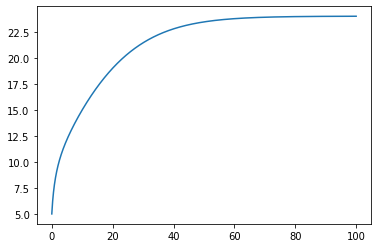

In [26]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
plt.show()

이제 아래 그림과 같은 경사로를 넘어 차량을 운전해보겠습니다.

![ramp](ramp.png)

슬로프를 오르기 위해 아래 그림과 같은 스로틀 입력이 20초 동안 제공됩니다.

![throttle](throttle.png)

차량의 스로틀 입력은 20%부터 시작해서 점차적으로 50%로 증가합니다.
이것은 차량이 가파른 경사를 올라갈 때 10초 동안 유지됩니다.
그 후 차량은 스로틀을 0으로 줄입니다.

아래 셀에서 램프 각도 $\alpha (x)$와 스로틀 $x_\theta (t)$을 구현하고 차량역학을 이용해서 단계별로 진행합니다.
차량 위치 $x(t)$는 $\textit{x_data}$에 저장됩니다.
저장된 차량의 위치는 솔루션을 평가하는데 사용됩니다.

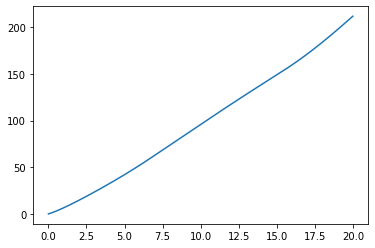

In [27]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
throttle_data = np.zeros_like(t_data)
alpha_data = np.zeros_like(t_data)

# reset the states
model.reset()

# ==================================
#  Learner solution begins here
# ==================================

n = t_data.shape[0]
throttle_data[:n//4] = [0.2 + 0.3 * i / (n//4) for i in range(n//4)]
throttle_data[n//4:3*n//4] = 0.5
throttle_data[3*n//4:] = [0.5 - 0.001 * i for i in range(n//4)]
for i in range(n):
    x_data[i] = model.x
    v_data[i] = model.v
    if model.x < 60:
        alpha_data[i] = np.arctan2(3, 60)
    elif model.x < 150:
        alpha_data[i] = np.arctan2(9, 90)
    model.step(throttle_data[i], alpha_data[i])


# ==================================
#  Learner solution ends here
# ==================================

# Plot x vs t for visualization
plt.plot(t_data, x_data)
plt.show()